In [22]:
from sympy import var,Function,Symbol,Rational
from ComputabilityGraphs.CMTVS import CMTVS
from bgc_md2.helper import bgc_md2_computers
from bgc_md2.resolve.mvars import (
    InFluxesBySymbol,
    OutFluxesBySymbol,
    InternalFluxesBySymbol,
    TimeSymbol,
    StateVariableTuple,
)

In [2]:
# obtain dictionary of symbols for equations from txt file
params_in = open(r"mini_model_sym_dict.txt", 'r')
sym_dict = {}
for line in params_in:
    k, v = line.strip().split('=')
    sym_dict[k.strip()] = v.strip()
    
params_in.close()

In [29]:
#define all the symbols you are going to use in the equations

for k in sym_dict.keys():
    code=k+" = Symbol('{0}')".format(k)
    exec(code)
    
func_dict = {
    "Gpp_grass": "Total C production for grass in g/m^2*month FIXME"
}
for k in func_dict.keys():
    code=k+" = Function('{0}')".format(k)
    exec(code)    
    
#I_wood=Function("I_wood") 
t=TimeSymbol("t") # the symbol used for time since it has a special role
e = Symbol("e")   # for exponential functions

cprodc_B = 1 - cprodc_A
k_STRUCC_1 = dec1_1 * defac_0 * (e**(-3*strlig_1))   # total C flow from surf strucc layer

# formulate the model
mvs = CMTVS(
    {
        StateVariableTuple( # the pool names in your preferred order
            (
                AGLIVC,
                BGLIVC,
                STDEDC,
                STRUCC_1,
                STRUCC_2,
                SOM1C_1,
                SOM1C_2,
                SOM2C,
                SOM3C,
                METABC_1,
                METABC_2,
                CROOTC,
                FBRCHC,
                FROOTC,
                RLEAVC,
                RLWODC,
                WOOD1C,
                WOOD2C,
                WOOD3C,
            )
        ), 
        t, 
        InFluxesBySymbol({
            AGLIVC: Gpp_grass(t)*cprodc_A, 
            BGLIVC: Gpp_grass(t)*cprodc_B
        }),
        OutFluxesBySymbol({    # CO2 losses
            STDEDC: fallrt * STDEDC,
            STRUCC_1: ((k_STRUCC_1 * Rational(3,10) * strlig_1) + (Rational(45,100)* k_STRUCC_1 * (1 - strlig_1))) * STRUCC_1,
            STRUCC_2: (dec1_2 * defac_0 * (e**(-3*strlig_2))) * STRUCC_2  # anerb=1 see litdec.F
        }),
        InternalFluxesBySymbol({
            (STRUCC_1, SOM1C_1): Rational(55,100) * (k_STRUCC_1 * (1 - strlig_1)) * STRUCC_1,
            (STRUCC_1, SOM2C): (dec1_1 * defac_0 * (e**(-3*strlig_1))) * (Rational(7,10) * strlig_1) * STRUCC_1  
        }),
    },
    bgc_md2_computers()

)

In [30]:
#start to query the model description..
M=mvs.get_CompartmentalMatrix()
#M.inverse_LU()

In [31]:
mvs.get_InputTuple()

Matrix([
[      cprodc_A*Gpp_grass(t)],
[(1 - cprodc_A)*Gpp_grass(t)],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0],
[                          0]])

In [32]:
mvs.get_StateVariableTuple()

Matrix([
[  AGLIVC],
[  BGLIVC],
[  STDEDC],
[STRUCC_1],
[STRUCC_2],
[ SOM1C_1],
[ SOM1C_2],
[   SOM2C],
[   SOM3C],
[METABC_1],
[METABC_2],
[  CROOTC],
[  FBRCHC],
[  FROOTC],
[  RLEAVC],
[  RLWODC],
[  WOOD1C],
[  WOOD2C],
[  WOOD3C]])

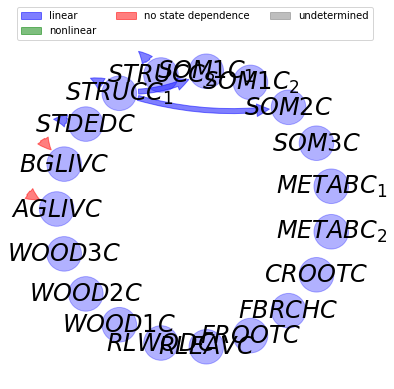

In [33]:
from bgc_md2.helper import compartmental_graph
compartmental_graph(mvs)

In [34]:
from bgc_md2.display_helpers import mass_balance_equation
mass_balance_equation(mvs)

<IPython.core.display.Math object>

In [35]:
# for comparison the century model as found in our database
from bgc_md2.models.Parton1987SoilSciSocAmJ.source_by_name import mvs as mvs_century

In [36]:
mvs.computable_mvar_types()

frozenset({CompartmentalSystems.smooth_reservoir_model.SmoothReservoirModel,
           bgc_md2.resolve.mvars.CompartmentalMatrix,
           bgc_md2.resolve.mvars.InFluxesBySymbol,
           bgc_md2.resolve.mvars.InputTuple,
           bgc_md2.resolve.mvars.InternalFluxesBySymbol,
           bgc_md2.resolve.mvars.OutFluxesBySymbol,
           bgc_md2.resolve.mvars.StateVariableTuple,
           bgc_md2.resolve.mvars.TimeSymbol})

In [37]:
mvs_century.get_InputTuple()

Matrix([
[J_surf*(0.018*LN + 0.15)],
[J_surf*(0.85 - 0.018*LN)],
[J_soil*(0.018*LN + 0.15)],
[J_soil*(0.85 - 0.018*LN)],
[                       0],
[                       0],
[                       0]])

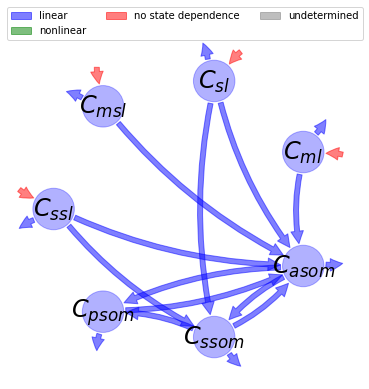

In [38]:
compartmental_graph(mvs_century)

In [39]:
mass_balance_equation(mvs_century)

<IPython.core.display.Math object>

In [40]:
BI=mvs_century.get_BibInfo()
BI.sym_dict

{'C_ssl': 'structural soil surface litter pool',
 'C_msl': 'metabolic soil surface litter pool',
 'C_sl': 'structural soil litter pool',
 'C_ml': 'metabolic soil litter pool',
 'C_asom': 'active soil organic matter pool',
 'C_ssom': 'slow soil organic matter pool',
 'C_psom': 'passive soil organic matter pool',
 'K_ssl': 'maximum decomposition rate of structural soil surface litter',
 'K_msl': 'maximum decomposition rate of metabolic soil surface litter',
 'K_sl': 'maximum decomposition rate of structural soil litter',
 'K_ml': 'maximum decomposition rate of metabolic soil litter',
 'K_asom': 'maximum decomposition rate of active soil organic matter',
 'K_ssom': 'maximum decomposition rate of slow soil organic matter',
 'K_psom': 'maximum decomposition rate of passive organic matter',
 'k_ssl': 'decomposition rate of structural soil surface litter',
 'k_sl': 'decomposition rate of structural soil litter',
 'k_asom': 'decomposition rate of active soil organic matter',
 'LN': 'lignin-to-

In [15]:
x=Symbol("x")

In [16]:
s=x**2-x

s

x**2 - x

In [21]:
from sympy import Rational
Rational(45,100)

9/20